<a href="https://colab.research.google.com/github/Rhanbouri/emines_ts/blob/Internet-of-Things/Time_Series_in_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import os
import sys

import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [94]:
url = "https://raw.githubusercontent.com/alexisperrier/emines_ts/master/data/train_ML_IOT.csv"
df = pd.read_csv(url)
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [95]:
df=df[df['Junction']==1]
df['Year'] = [date.year for date in df.DateTime]

In [96]:
df=df[df['Year']==2015]

In [97]:
df

,DateTime,Junction,Vehicles,ID,Year
0,2015-11-01 00:00:00,1,15,20151101001,2015
1,2015-11-01 01:00:00,1,13,20151101011,2015
2,2015-11-01 02:00:00,1,10,20151101021,2015
3,2015-11-01 03:00:00,1,7,20151101031,2015
4,2015-11-01 04:00:00,1,9,20151101041,2015
...,...,...,...,...,...
1459,2015-12-31 19:00:00,1,21,20151231191,2015
1460,2015-12-31 20:00:00,1,18,20151231201,2015
1461,2015-12-31 21:00:00,1,17,20151231211,2015
1462,2015-12-31 22:00:00,1,14,20151231221,2015


In [99]:
ts = pd.Series(data = df.Vehicles.values, index = df['DateTime'])
ts


DateTime
2015-11-01 00:00:00    15
2015-11-01 01:00:00    13
2015-11-01 02:00:00    10
2015-11-01 03:00:00     7
2015-11-01 04:00:00     9
                       ..
2015-12-31 19:00:00    21
2015-12-31 20:00:00    18
2015-12-31 21:00:00    17
2015-12-31 22:00:00    14
2015-12-31 23:00:00    15
Length: 1464, dtype: int64

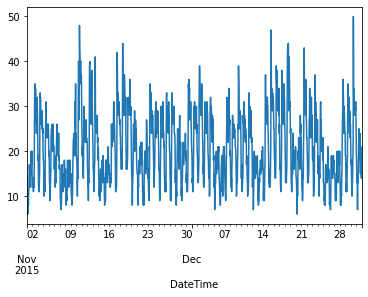

In [100]:
ts.plot()

# white noise: Ljung box


In [109]:
import statsmodels.api as sm
res = sm.stats.acorr_ljungbox(ts)
print(f"Resultat du test Ljung-Box p-value: {  res[1][0] }")

Resultat du test Ljung-Box p-value: 3.799543963202639e-242


# Stationarité 



In [111]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(ts)

print(f"la p-value est {res[1]} < 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  ")

la p-value est 0.004543396291786776 < 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  


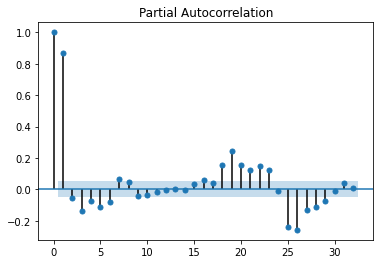

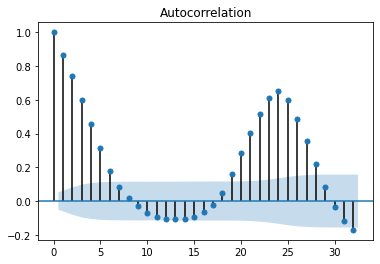

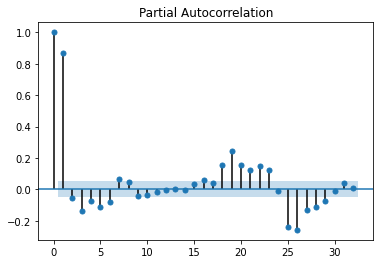

In [112]:
# import statsmodels.tsa.api as smt
smt.graphics.plot_acf(ts.values)
smt.graphics.plot_pacf(ts.values)

In [113]:
est_order = smt.AR(ts.values).select_order(maxlag=32, ic='aic', trend='c')
est_order

29

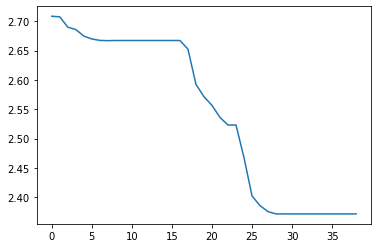

In [114]:
score = []
for i in range(1,40):
    mdl = smt.AR(ts.values).fit(maxlag=i, ic='aic', trend='c')
    # plt.plot(mdl.params)
    score.append(mdl.aic)
plt.plot(score)

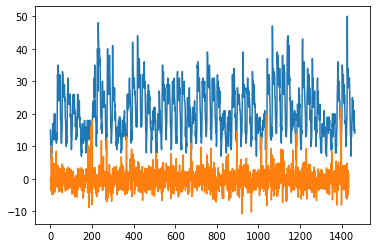

In [115]:
plt.plot(ts.values)
plt.plot(mdl.resid)

# modelisation AR sur la difference


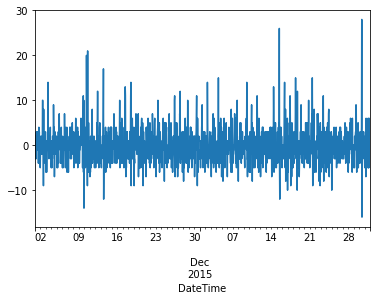

In [116]:
d = ts.diff()
d = d[~d.isna()]

d.plot()


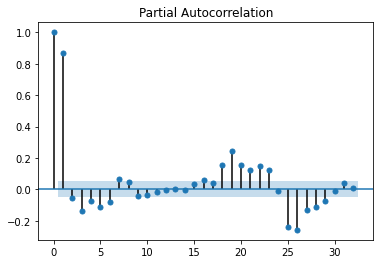

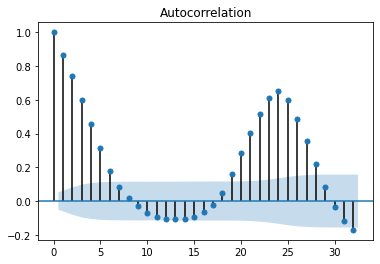

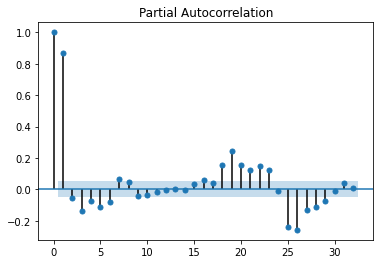

In [117]:
smt.graphics.plot_acf(ts.values)
smt.graphics.plot_pacf(ts.values)


In [118]:
score_bic = []
score_mse = []
for i in range(1,30):
    mdl = smt.AR(ts.values).fit(maxlag=i, ic='bic', trend='c')
    score_bic.append(mdl.bic)
    n_fitted = len(mdl.fittedvalues)
    score_mse.append( mse( mdl.fittedvalues, d.values[:n_fitted]  ))  


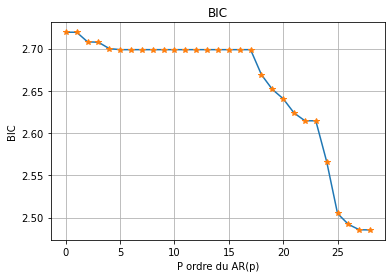

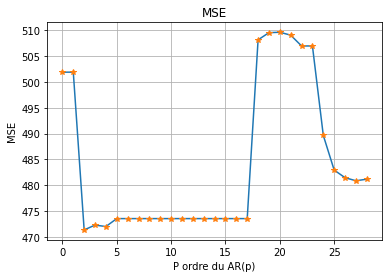

In [119]:
fig, ax = plt.subplots(1,1)
plt.title("BIC")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("BIC")
plt.plot(score_bic)
plt.plot(score_bic, '*')
plt.grid()

fig, ax = plt.subplots(1,1)
plt.title("MSE")
plt.xlabel("P ordre du AR(p)")
plt.ylabel("MSE")
plt.plot(score_mse)
plt.plot(score_mse, '*')
plt.grid()

In [120]:
mdl = smt.AR(d.values).fit(maxlag=29, ic='bic', trend='c')

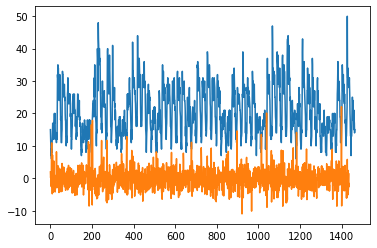

In [123]:
plt.plot(ts.values)
plt.plot(mdl.resid)

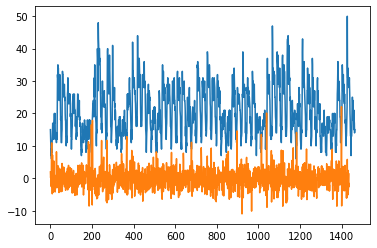

In [124]:
mdl = smt.AR(d.values).fit(maxlag=29, ic='bic', trend='c')
plt.plot(ts.values)
plt.plot(mdl.resid)


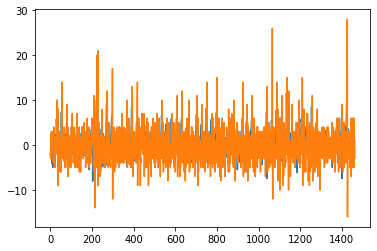

In [125]:
plt.plot(mdl.fittedvalues)
plt.plot(d.values)

In [130]:
mdl

# ARIMA - grid search



In [131]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        y.hist(bins = 20, ax = pp_ax)
        # scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

In [132]:

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(ts.values, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:51

aic: 7979.55011 | order: (4, 1, 3)


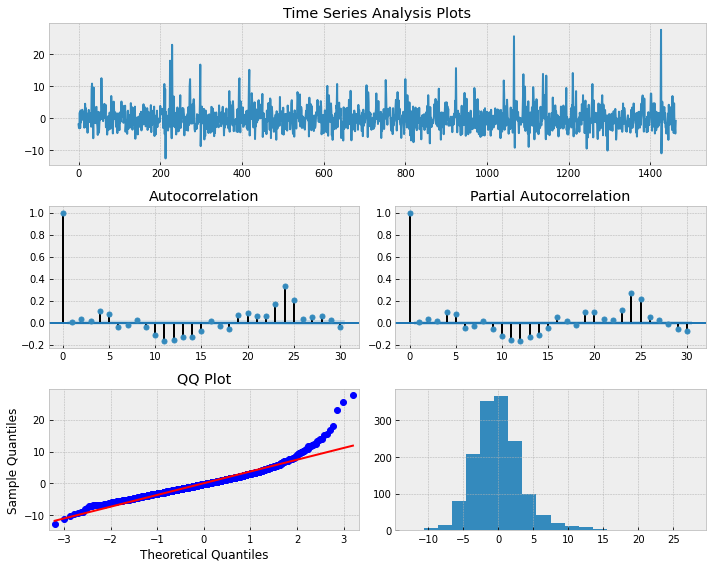

In [133]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

# Decomposition

## Additive

In [ ]:
result = seasonal_decompose(ts, model='additive')

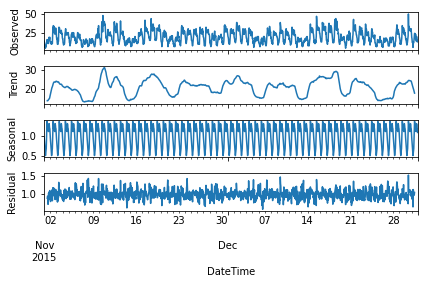

In [ ]:
result.plot()
plt.show()

## Multiplicative

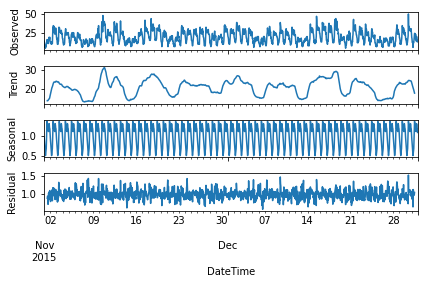

In [ ]:
result = seasonal_decompose(ts, model='multiplicative')
result.plot()
plt.show()
